In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, load_model
from keras.layers import Input, BatchNormalization, Activation, GlobalAveragePooling2D, UpSampling2D
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score

import seaborn as sns

import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt

def prepare_dataset(dataframe, image_size={'width':48, 'height':48}):
    faces_images = []
    pixels = dataframe['pixels'].tolist()
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(image_size['width'], image_size['height'])
        face = cv2.resize(face.astype('uint8'), (image_size['width'], image_size['height']))        
        faces_images.append(face.astype('float32') / 255.0)
    faces_images = np.asarray(faces_images)
    faces_images = np.expand_dims(faces_images, -1) # (1, 48, 48)
    emotions_labels = pd.get_dummies(dataframe['emotion']).as_matrix()
    return faces_images, emotions_labels
  
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

Using TensorFlow backend.


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
! pip install pydrive

# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from google.colab import files

    100% |████████████████████████████████| 993kB 11.3MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [4]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1Yln-m9Fuo4fIJ0enTHUSw-Nf7Fq7gA1_'
downloaded = drive.CreateFile({'id': file_id})
# allows to load file in the notebook

# assume the file is called file.csv and it's located at the root of your drive
downloaded.GetContentFile('fer2013.csv')

dataset = pd.read_csv('fer2013.csv')
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
# dataset = pd.read_csv('../input/fer2013.csv')

In [0]:
emotions_labels_map = {'angry':0,
                       'disgust':1, 
                       'fear':2, 
                       'happy':3, 
                       'sad':4, 
                       'surprise':5, 
                       'neutral':6}

groups = dataset.groupby('Usage')

# get group - training
training_data = groups.get_group('Training')

# get groups on training split by emotion
training_emotions = training_data.groupby('emotion')

# get group - test
test_data = groups.get_group('PublicTest')

# get groups on test split by emotion
test_emotions = test_data.groupby('emotion')

# get group - validation
validation_data = groups.get_group('PrivateTest')

# get groups on validation split by emotion
validation_emotions = validation_data.groupby('emotion')

# prepare dataset to training, test and validate model
training_faces, training_emotions = prepare_dataset(training_data)
test_faces, test_emotions = prepare_dataset(test_data)
validation_faces, validation_emotions = prepare_dataset(validation_data)

# get size dataset elements
num_samples, num_classes = training_emotions.shape

# split and randomize data
x_train_part1, x_train_part2, y_train_part1, y_train_part2 = train_test_split(training_faces, training_emotions, test_size=0.3, random_state=42)
x_train, y_train = np.vstack((x_train_part1, x_train_part2)), np.vstack((y_train_part1, y_train_part2))

x_test_part1, x_test_part2, y_test_part1, y_test_part2 = train_test_split(test_faces, test_emotions, test_size=0.3, random_state=42)
x_test, y_test = np.vstack((x_test_part1, x_test_part2)), np.vstack((y_test_part1, y_test_part2))

x_validation_part1, x_validation_part2, y_validation_part1, y_validation_part2 = train_test_split(validation_faces, validation_emotions, test_size=0.3, random_state=42)
x_validation, y_validation = np.vstack((x_validation_part1, x_validation_part2)), np.vstack((y_validation_part1, y_validation_part2))

In [0]:
# create data augmention
data_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
data_generator.fit(x_train)
data_generator.fit(x_test)
data_generator.fit(x_validation)

In [0]:
model_names = 'acc_{val_acc:.2f}.hdf5'
patience = 50
batch_size = 86
num_epochs = 100

early_stop = EarlyStopping(monitor='val_acc', patience=patience, mode='max')
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=(patience//4))
callbacks = [early_stop, reduce_lr]

In [0]:
model = Sequential()
model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same', input_shape=(48, 48, 1), kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Flatten())
model.add(Dense(512, kernel_initializer='glorot_uniform', activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(512, kernel_initializer='glorot_uniform', activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta, 'accuracy'])

In [10]:
%%time
history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size),
                    steps_per_epoch=len(x_train) / batch_size,
                    epochs=num_epochs, verbose=True, callbacks=callbacks,
                    validation_data=(x_test, y_test))

Epoch 1/100
334/333 [==============================] - 37s 110ms/step - loss: 1.7867 - fbeta: 0.0143 - acc: 0.2656 - val_loss: 1.6606 - val_fbeta: 0.0351 - val_acc: 0.3422
Epoch 2/100
222/333 [==================>...........] - ETA: 10s - loss: 1.6980 - fbeta: 0.0560 - acc: 0.3229

334/333 [==============================] - 33s 99ms/step - loss: 1.6870 - fbeta: 0.0602 - acc: 0.3265 - val_loss: 1.6227 - val_fbeta: 0.0906 - val_acc: 0.3427
Epoch 3/100
329/333 [============================>.] - ETA: 0s - loss: 1.6298 - fbeta: 0.1022 - acc: 0.3590

334/333 [==============================] - 33s 98ms/step - loss: 1.6307 - fbeta: 0.1021 - acc: 0.3590 - val_loss: 1.5678 - val_fbeta: 0.1337 - val_acc: 0.3867
Epoch 4/100
334/333 [==============================] - 32s 96ms/step - loss: 1.5974 - fbeta: 0.1222 - acc: 0.3743 - val_loss: 1.4906 - val_fbeta: 0.1803 - val_acc: 0.4166
Epoch 5/100
 20/333 [>.............................] - ETA: 30s - loss: 1.5872 - fbeta: 0.1372 - acc: 0.3744

334/333 [==============================] - 32s 96ms/step - loss: 1.5773 - fbeta: 0.1336 - acc: 0.3810 - val_loss: 1.5505 - val_fbeta: 0.1638 - val_acc: 0.3667
Epoch 6/100
257/333 [======================>.......] - ETA: 7s - loss: 1.5504 - fbeta: 0.1452 - acc: 0.3897

334/333 [==============================] - 33s 98ms/step - loss: 1.5485 - fbeta: 0.1465 - acc: 0.3922 - val_loss: 1.4260 - val_fbeta: 0.2059 - val_acc: 0.4447
Epoch 7/100
334/333 [==============================] - 32s 96ms/step - loss: 1.5232 - fbeta: 0.1600 - acc: 0.4032 - val_loss: 1.4376 - val_fbeta: 0.2360 - val_acc: 0.4441
Epoch 8/100
  6/333 [..............................] - ETA: 31s - loss: 1.5344 - fbeta: 0.1415 - acc: 0.3895

334/333 [==============================] - 33s 98ms/step - loss: 1.5024 - fbeta: 0.1668 - acc: 0.4115 - val_loss: 1.3853 - val_fbeta: 0.2051 - val_acc: 0.4692
Epoch 9/100
249/333 [=====================>........] - ETA: 7s - loss: 1.4780 - fbeta: 0.1773 - acc: 0.4274

334/333 [==============================] - 33s 98ms/step - loss: 1.4786 - fbeta: 0.1795 - acc: 0.4306 - val_loss: 1.3804 - val_fbeta: 0.2190 - val_acc: 0.4586
Epoch 10/100
334/333 [==============================] - 32s 97ms/step - loss: 1.4612 - fbeta: 0.1870 - acc: 0.4339 - val_loss: 1.3625 - val_fbeta: 0.2360 - val_acc: 0.4717
Epoch 11/100
  1/333 [..............................] - ETA: 30s - loss: 1.5780 - fbeta: 0.1395 - acc: 0.4186

334/333 [==============================] - 33s 98ms/step - loss: 1.4366 - fbeta: 0.2017 - acc: 0.4422 - val_loss: 1.3655 - val_fbeta: 0.2168 - val_acc: 0.4784
Epoch 12/100
250/333 [=====================>........] - ETA: 8s - loss: 1.4241 - fbeta: 0.2059 - acc: 0.4518

334/333 [==============================] - 33s 99ms/step - loss: 1.4207 - fbeta: 0.2073 - acc: 0.4524 - val_loss: 1.3382 - val_fbeta: 0.2460 - val_acc: 0.4817
Epoch 13/100
334/333 [==============================] - 33s 98ms/step - loss: 1.4049 - fbeta: 0.2193 - acc: 0.4600 - val_loss: 1.2973 - val_fbeta: 0.2820 - val_acc: 0.5004
Epoch 14/100
  1/333 [..............................] - ETA: 35s - loss: 1.3675 - fbeta: 0.1628 - acc: 0.4186

334/333 [==============================] - 32s 96ms/step - loss: 1.3870 - fbeta: 0.2283 - acc: 0.4664 - val_loss: 1.3328 - val_fbeta: 0.2608 - val_acc: 0.4946
Epoch 15/100
246/333 [=====================>........] - ETA: 8s - loss: 1.3777 - fbeta: 0.2334 - acc: 0.4710

334/333 [==============================] - 33s 98ms/step - loss: 1.3747 - fbeta: 0.2348 - acc: 0.4695 - val_loss: 1.2915 - val_fbeta: 0.2831 - val_acc: 0.5052
Epoch 16/100
334/333 [==============================] - 32s 97ms/step - loss: 1.3600 - fbeta: 0.2440 - acc: 0.4755 - val_loss: 1.2602 - val_fbeta: 0.3151 - val_acc: 0.5166
Epoch 17/100
  2/333 [..............................] - ETA: 33s - loss: 1.3701 - fbeta: 0.2442 - acc: 0.4884

334/333 [==============================] - 33s 99ms/step - loss: 1.3482 - fbeta: 0.2526 - acc: 0.4799 - val_loss: 1.2724 - val_fbeta: 0.2836 - val_acc: 0.5127
Epoch 18/100
248/333 [=====================>........] - ETA: 8s - loss: 1.3407 - fbeta: 0.2564 - acc: 0.4849

334/333 [==============================] - 33s 98ms/step - loss: 1.3407 - fbeta: 0.2545 - acc: 0.4846 - val_loss: 1.2395 - val_fbeta: 0.3327 - val_acc: 0.5194
Epoch 19/100
334/333 [==============================] - 32s 97ms/step - loss: 1.3279 - fbeta: 0.2614 - acc: 0.4870 - val_loss: 1.2216 - val_fbeta: 0.3076 - val_acc: 0.5369
Epoch 20/100
  2/333 [..............................] - ETA: 32s - loss: 1.3322 - fbeta: 0.2674 - acc: 0.5116

334/333 [==============================] - 33s 99ms/step - loss: 1.3174 - fbeta: 0.2680 - acc: 0.4957 - val_loss: 1.2433 - val_fbeta: 0.3196 - val_acc: 0.5160
Epoch 21/100
251/333 [=====================>........] - ETA: 7s - loss: 1.2990 - fbeta: 0.2792 - acc: 0.5022

334/333 [==============================] - 33s 100ms/step - loss: 1.3038 - fbeta: 0.2778 - acc: 0.5003 - val_loss: 1.2310 - val_fbeta: 0.2998 - val_acc: 0.5266
Epoch 22/100
334/333 [==============================] - 33s 98ms/step - loss: 1.2942 - fbeta: 0.2753 - acc: 0.4980 - val_loss: 1.2301 - val_fbeta: 0.3316 - val_acc: 0.5227


Epoch 23/100
334/333 [==============================] - 32s 96ms/step - loss: 1.2918 - fbeta: 0.2817 - acc: 0.5035 - val_loss: 1.2236 - val_fbeta: 0.3430 - val_acc: 0.5305
Epoch 24/100
222/333 [==================>...........] - ETA: 10s - loss: 1.2760 - fbeta: 0.2928 - acc: 0.5121

334/333 [==============================] - 33s 99ms/step - loss: 1.2799 - fbeta: 0.2882 - acc: 0.5096 - val_loss: 1.2227 - val_fbeta: 0.3341 - val_acc: 0.5288
Epoch 25/100
329/333 [============================>.] - ETA: 0s - loss: 1.2685 - fbeta: 0.2971 - acc: 0.5124

334/333 [==============================] - 33s 97ms/step - loss: 1.2686 - fbeta: 0.2970 - acc: 0.5123 - val_loss: 1.1980 - val_fbeta: 0.3759 - val_acc: 0.5422
Epoch 26/100
334/333 [==============================] - 32s 96ms/step - loss: 1.2643 - fbeta: 0.2990 - acc: 0.5132 - val_loss: 1.2284 - val_fbeta: 0.3923 - val_acc: 0.5196
Epoch 27/100
 22/333 [>.............................] - ETA: 31s - loss: 1.2692 - fbeta: 0.3155 - acc: 0.5206

334/333 [==============================] - 32s 97ms/step - loss: 1.2584 - fbeta: 0.3021 - acc: 0.5168 - val_loss: 1.1984 - val_fbeta: 0.3686 - val_acc: 0.5336
Epoch 28/100
249/333 [=====================>........] - ETA: 8s - loss: 1.2458 - fbeta: 0.3121 - acc: 0.5228

334/333 [==============================] - 33s 98ms/step - loss: 1.2495 - fbeta: 0.3117 - acc: 0.5228 - val_loss: 1.1601 - val_fbeta: 0.3592 - val_acc: 0.5614
Epoch 29/100
334/333 [==============================] - 33s 98ms/step - loss: 1.2420 - fbeta: 0.3162 - acc: 0.5233 - val_loss: 1.1628 - val_fbeta: 0.3714 - val_acc: 0.5508
Epoch 30/100
  4/333 [..............................] - ETA: 27s - loss: 1.2452 - fbeta: 0.3110 - acc: 0.5378

334/333 [==============================] - 33s 100ms/step - loss: 1.2428 - fbeta: 0.3123 - acc: 0.5250 - val_loss: 1.1439 - val_fbeta: 0.3814 - val_acc: 0.5481
Epoch 31/100
248/333 [=====================>........] - ETA: 8s - loss: 1.2313 - fbeta: 0.3238 - acc: 0.5310

334/333 [==============================] - 33s 98ms/step - loss: 1.2296 - fbeta: 0.3237 - acc: 0.5304 - val_loss: 1.1866 - val_fbeta: 0.3873 - val_acc: 0.5464
Epoch 32/100
334/333 [==============================] - 32s 97ms/step - loss: 1.2278 - fbeta: 0.3233 - acc: 0.5308 - val_loss: 1.1745 - val_fbeta: 0.3700 - val_acc: 0.5469
Epoch 33/100
  1/333 [..............................] - ETA: 32s - loss: 1.1322 - fbeta: 0.3488 - acc: 0.5814

334/333 [==============================] - 32s 97ms/step - loss: 1.2226 - fbeta: 0.3261 - acc: 0.5317 - val_loss: 1.1793 - val_fbeta: 0.3773 - val_acc: 0.5456
Epoch 34/100
247/333 [=====================>........] - ETA: 8s - loss: 1.2108 - fbeta: 0.3325 - acc: 0.5362

334/333 [==============================] - 32s 97ms/step - loss: 1.2132 - fbeta: 0.3321 - acc: 0.5360 - val_loss: 1.1435 - val_fbeta: 0.3787 - val_acc: 0.5589
Epoch 35/100
334/333 [==============================] - 33s 98ms/step - loss: 1.2133 - fbeta: 0.3293 - acc: 0.5374 - val_loss: 1.1211 - val_fbeta: 0.4154 - val_acc: 0.5662
Epoch 36/100
  3/333 [..............................] - ETA: 33s - loss: 1.2128 - fbeta: 0.3450 - acc: 0.4961

334/333 [==============================] - 32s 96ms/step - loss: 1.2003 - fbeta: 0.3396 - acc: 0.5395 - val_loss: 1.1827 - val_fbeta: 0.3904 - val_acc: 0.5528
Epoch 37/100
248/333 [=====================>........] - ETA: 8s - loss: 1.1939 - fbeta: 0.3466 - acc: 0.5468

334/333 [==============================] - 33s 98ms/step - loss: 1.2024 - fbeta: 0.3420 - acc: 0.5435 - val_loss: 1.1466 - val_fbeta: 0.3564 - val_acc: 0.5612
Epoch 38/100
334/333 [==============================] - 32s 97ms/step - loss: 1.1908 - fbeta: 0.3446 - acc: 0.5445 - val_loss: 1.1405 - val_fbeta: 0.3527 - val_acc: 0.5642
Epoch 39/100
  4/333 [..............................] - ETA: 28s - loss: 1.1399 - fbeta: 0.3634 - acc: 0.5959

334/333 [==============================] - 33s 98ms/step - loss: 1.1856 - fbeta: 0.3461 - acc: 0.5479 - val_loss: 1.1231 - val_fbeta: 0.4202 - val_acc: 0.5737
Epoch 40/100
249/333 [=====================>........] - ETA: 8s - loss: 1.1789 - fbeta: 0.3469 - acc: 0.5462

334/333 [==============================] - 33s 99ms/step - loss: 1.1796 - fbeta: 0.3484 - acc: 0.5477 - val_loss: 1.1990 - val_fbeta: 0.4132 - val_acc: 0.5439
Epoch 41/100
334/333 [==============================] - 33s 98ms/step - loss: 1.1786 - fbeta: 0.3512 - acc: 0.5499 - val_loss: 1.1302 - val_fbeta: 0.4126 - val_acc: 0.5589
Epoch 42/100
  3/333 [..............................] - ETA: 32s - loss: 1.1457 - fbeta: 0.3876 - acc: 0.5465

334/333 [==============================] - 33s 98ms/step - loss: 1.1818 - fbeta: 0.3516 - acc: 0.5513 - val_loss: 1.1058 - val_fbeta: 0.4051 - val_acc: 0.5768
Epoch 43/100
246/333 [=====================>........] - ETA: 8s - loss: 1.1698 - fbeta: 0.3559 - acc: 0.5519

334/333 [==============================] - 33s 98ms/step - loss: 1.1712 - fbeta: 0.3567 - acc: 0.5524 - val_loss: 1.1233 - val_fbeta: 0.3965 - val_acc: 0.5704
Epoch 44/100
334/333 [==============================] - 32s 96ms/step - loss: 1.1698 - fbeta: 0.3620 - acc: 0.5567 - val_loss: 1.1605 - val_fbeta: 0.4107 - val_acc: 0.5520
Epoch 45/100
  4/333 [..............................] - ETA: 31s - loss: 1.1638 - fbeta: 0.3430 - acc: 0.5349

334/333 [==============================] - 33s 99ms/step - loss: 1.1657 - fbeta: 0.3618 - acc: 0.5532 - val_loss: 1.0916 - val_fbeta: 0.4009 - val_acc: 0.5843
Epoch 46/100
251/333 [=====================>........] - ETA: 7s - loss: 1.1631 - fbeta: 0.3639 - acc: 0.5536

334/333 [==============================] - 33s 99ms/step - loss: 1.1625 - fbeta: 0.3662 - acc: 0.5551 - val_loss: 1.1323 - val_fbeta: 0.4400 - val_acc: 0.5628
Epoch 47/100
334/333 [==============================] - 33s 99ms/step - loss: 1.1642 - fbeta: 0.3653 - acc: 0.5564 - val_loss: 1.0991 - val_fbeta: 0.4305 - val_acc: 0.5821
Epoch 48/100
  1/333 [..............................] - ETA: 29s - loss: 1.2945 - fbeta: 0.3023 - acc: 0.4884

334/333 [==============================] - 32s 96ms/step - loss: 1.1635 - fbeta: 0.3637 - acc: 0.5578 - val_loss: 1.1336 - val_fbeta: 0.4288 - val_acc: 0.5645
Epoch 49/100
245/333 [=====================>........] - ETA: 8s - loss: 1.1510 - fbeta: 0.3746 - acc: 0.5608

334/333 [==============================] - 33s 97ms/step - loss: 1.1522 - fbeta: 0.3753 - acc: 0.5618 - val_loss: 1.1039 - val_fbeta: 0.4096 - val_acc: 0.5818
Epoch 50/100
334/333 [==============================] - 34s 101ms/step - loss: 1.1502 - fbeta: 0.3707 - acc: 0.5605 - val_loss: 1.0860 - val_fbeta: 0.3904 - val_acc: 0.5823
Epoch 51/100
  1/333 [..............................] - ETA: 32s - loss: 1.1922 - fbeta: 0.3488 - acc: 0.5000

334/333 [==============================] - 33s 98ms/step - loss: 1.1440 - fbeta: 0.3746 - acc: 0.5629 - val_loss: 1.1284 - val_fbeta: 0.4333 - val_acc: 0.5768
Epoch 52/100
248/333 [=====================>........] - ETA: 8s - loss: 1.1475 - fbeta: 0.3747 - acc: 0.5623

334/333 [==============================] - 33s 99ms/step - loss: 1.1435 - fbeta: 0.3765 - acc: 0.5644 - val_loss: 1.0747 - val_fbeta: 0.4232 - val_acc: 0.5963
Epoch 53/100
334/333 [==============================] - 32s 96ms/step - loss: 1.1398 - fbeta: 0.3798 - acc: 0.5654 - val_loss: 1.1014 - val_fbeta: 0.4235 - val_acc: 0.5809
Epoch 54/100
  2/333 [..............................] - ETA: 29s - loss: 1.2347 - fbeta: 0.3140 - acc: 0.5116

334/333 [==============================] - 32s 97ms/step - loss: 1.1386 - fbeta: 0.3796 - acc: 0.5686 - val_loss: 1.1113 - val_fbeta: 0.4163 - val_acc: 0.5756
Epoch 55/100
243/333 [====================>.........] - ETA: 8s - loss: 1.1326 - fbeta: 0.3841 - acc: 0.5674

334/333 [==============================] - 33s 99ms/step - loss: 1.1359 - fbeta: 0.3824 - acc: 0.5656 - val_loss: 1.0772 - val_fbeta: 0.3926 - val_acc: 0.5960
Epoch 56/100
334/333 [==============================] - 33s 99ms/step - loss: 1.1330 - fbeta: 0.3824 - acc: 0.5667 - val_loss: 1.1135 - val_fbeta: 0.4461 - val_acc: 0.5723


Epoch 57/100
334/333 [==============================] - 33s 99ms/step - loss: 1.1313 - fbeta: 0.3813 - acc: 0.5699 - val_loss: 1.1845 - val_fbeta: 0.4400 - val_acc: 0.5573
Epoch 58/100
217/333 [==================>...........] - ETA: 11s - loss: 1.1233 - fbeta: 0.3882 - acc: 0.5693

334/333 [==============================] - 32s 97ms/step - loss: 1.1233 - fbeta: 0.3889 - acc: 0.5706 - val_loss: 1.0668 - val_fbeta: 0.4595 - val_acc: 0.5926
Epoch 59/100
328/333 [============================>.] - ETA: 0s - loss: 1.1220 - fbeta: 0.3865 - acc: 0.5705

334/333 [==============================] - 32s 96ms/step - loss: 1.1220 - fbeta: 0.3862 - acc: 0.5706 - val_loss: 1.0964 - val_fbeta: 0.4252 - val_acc: 0.5829
Epoch 60/100
334/333 [==============================] - 32s 96ms/step - loss: 1.1220 - fbeta: 0.3912 - acc: 0.5736 - val_loss: 1.0965 - val_fbeta: 0.4595 - val_acc: 0.5862
Epoch 61/100
 21/333 [>.............................] - ETA: 30s - loss: 1.1125 - fbeta: 0.4092 - acc: 0.5803

334/333 [==============================] - 33s 98ms/step - loss: 1.1207 - fbeta: 0.3903 - acc: 0.5706 - val_loss: 1.0721 - val_fbeta: 0.4544 - val_acc: 0.5910
Epoch 62/100
253/333 [=====================>........] - ETA: 7s - loss: 1.1150 - fbeta: 0.3911 - acc: 0.5697

334/333 [==============================] - 33s 98ms/step - loss: 1.1135 - fbeta: 0.3935 - acc: 0.5727 - val_loss: 1.0565 - val_fbeta: 0.4472 - val_acc: 0.5993
Epoch 63/100
334/333 [==============================] - 33s 97ms/step - loss: 1.1138 - fbeta: 0.3983 - acc: 0.5751 - val_loss: 1.0924 - val_fbeta: 0.4458 - val_acc: 0.5874
Epoch 64/100
  1/333 [..............................] - ETA: 33s - loss: 1.0985 - fbeta: 0.3488 - acc: 0.5116

334/333 [==============================] - 33s 98ms/step - loss: 1.1087 - fbeta: 0.3957 - acc: 0.5774 - val_loss: 1.0434 - val_fbeta: 0.4681 - val_acc: 0.6049
Epoch 65/100
251/333 [=====================>........] - ETA: 8s - loss: 1.1110 - fbeta: 0.3987 - acc: 0.5763

334/333 [==============================] - 33s 100ms/step - loss: 1.1066 - fbeta: 0.4003 - acc: 0.5783 - val_loss: 1.0551 - val_fbeta: 0.4553 - val_acc: 0.5985
Epoch 66/100
331/333 [============================>.] - ETA: 0s - loss: 1.1052 - fbeta: 0.4006 - acc: 0.5796

334/333 [==============================] - 32s 97ms/step - loss: 1.1054 - fbeta: 0.4004 - acc: 0.5794 - val_loss: 1.0849 - val_fbeta: 0.4232 - val_acc: 0.5812
Epoch 67/100
334/333 [==============================] - 32s 96ms/step - loss: 1.1095 - fbeta: 0.3947 - acc: 0.5753 - val_loss: 1.0849 - val_fbeta: 0.4648 - val_acc: 0.5834
Epoch 68/100
 20/333 [>.............................] - ETA: 31s - loss: 1.0849 - fbeta: 0.4099 - acc: 0.5808

334/333 [==============================] - 33s 98ms/step - loss: 1.1029 - fbeta: 0.4025 - acc: 0.5775 - val_loss: 1.0663 - val_fbeta: 0.4433 - val_acc: 0.5988
Epoch 69/100
256/333 [======================>.......] - ETA: 7s - loss: 1.0998 - fbeta: 0.4021 - acc: 0.5785

334/333 [==============================] - 32s 96ms/step - loss: 1.0959 - fbeta: 0.4028 - acc: 0.5801 - val_loss: 1.0797 - val_fbeta: 0.4642 - val_acc: 0.5851
Epoch 70/100
334/333 [==============================] - 32s 97ms/step - loss: 1.0966 - fbeta: 0.4111 - acc: 0.5822 - val_loss: 1.0425 - val_fbeta: 0.4511 - val_acc: 0.6024
Epoch 71/100
  5/333 [..............................] - ETA: 30s - loss: 1.0556 - fbeta: 0.4326 - acc: 0.6047

334/333 [==============================] - 32s 96ms/step - loss: 1.0980 - fbeta: 0.4059 - acc: 0.5814 - val_loss: 1.0668 - val_fbeta: 0.4544 - val_acc: 0.5946
Epoch 72/100
248/333 [=====================>........] - ETA: 8s - loss: 1.0942 - fbeta: 0.4075 - acc: 0.5818

334/333 [==============================] - 33s 98ms/step - loss: 1.0933 - fbeta: 0.4076 - acc: 0.5817 - val_loss: 1.0590 - val_fbeta: 0.4583 - val_acc: 0.6049
Epoch 73/100
334/333 [==============================] - 33s 97ms/step - loss: 1.0885 - fbeta: 0.4107 - acc: 0.5870 - val_loss: 1.0639 - val_fbeta: 0.4734 - val_acc: 0.6027
Epoch 74/100
  2/333 [..............................] - ETA: 31s - loss: 1.1710 - fbeta: 0.3721 - acc: 0.5523

334/333 [==============================] - 33s 99ms/step - loss: 1.0920 - fbeta: 0.4063 - acc: 0.5831 - val_loss: 1.0420 - val_fbeta: 0.4505 - val_acc: 0.6105
Epoch 75/100
246/333 [=====================>........] - ETA: 8s - loss: 1.0872 - fbeta: 0.4119 - acc: 0.5871

334/333 [==============================] - 33s 98ms/step - loss: 1.0887 - fbeta: 0.4122 - acc: 0.5866 - val_loss: 1.0431 - val_fbeta: 0.4553 - val_acc: 0.6049
Epoch 76/100
334/333 [==============================] - 33s 98ms/step - loss: 1.0871 - fbeta: 0.4106 - acc: 0.5881 - val_loss: 1.0522 - val_fbeta: 0.4606 - val_acc: 0.5929
Epoch 77/100
  1/333 [..............................] - ETA: 31s - loss: 1.1287 - fbeta: 0.3953 - acc: 0.6047

334/333 [==============================] - 33s 99ms/step - loss: 1.0843 - fbeta: 0.4123 - acc: 0.5870 - val_loss: 1.0405 - val_fbeta: 0.4533 - val_acc: 0.6046
Epoch 78/100
250/333 [=====================>........] - ETA: 7s - loss: 1.0790 - fbeta: 0.4156 - acc: 0.5873

334/333 [==============================] - 33s 98ms/step - loss: 1.0790 - fbeta: 0.4169 - acc: 0.5877 - val_loss: 1.0448 - val_fbeta: 0.4692 - val_acc: 0.5988
Epoch 79/100
334/333 [==============================] - 32s 97ms/step - loss: 1.0721 - fbeta: 0.4214 - acc: 0.5905 - val_loss: 1.0609 - val_fbeta: 0.4656 - val_acc: 0.5876
Epoch 80/100
  2/333 [..............................] - ETA: 33s - loss: 1.0898 - fbeta: 0.3837 - acc: 0.5814

334/333 [==============================] - 32s 97ms/step - loss: 1.0757 - fbeta: 0.4200 - acc: 0.5932 - val_loss: 1.0465 - val_fbeta: 0.4767 - val_acc: 0.6102
Epoch 81/100
244/333 [====================>.........] - ETA: 8s - loss: 1.0711 - fbeta: 0.4189 - acc: 0.5855

334/333 [==============================] - 32s 97ms/step - loss: 1.0704 - fbeta: 0.4212 - acc: 0.5876 - val_loss: 1.0487 - val_fbeta: 0.4625 - val_acc: 0.6055
Epoch 82/100
334/333 [==============================] - 33s 97ms/step - loss: 1.0731 - fbeta: 0.4205 - acc: 0.5903 - val_loss: 1.0577 - val_fbeta: 0.4374 - val_acc: 0.6030
Epoch 83/100
  3/333 [..............................] - ETA: 34s - loss: 1.1601 - fbeta: 0.3721 - acc: 0.5543

334/333 [==============================] - 33s 99ms/step - loss: 1.0704 - fbeta: 0.4211 - acc: 0.5920 - val_loss: 1.0429 - val_fbeta: 0.4781 - val_acc: 0.5971
Epoch 84/100
250/333 [=====================>........] - ETA: 7s - loss: 1.0770 - fbeta: 0.4186 - acc: 0.5914

334/333 [==============================] - 33s 98ms/step - loss: 1.0697 - fbeta: 0.4239 - acc: 0.5941 - val_loss: 1.0258 - val_fbeta: 0.4804 - val_acc: 0.6133
Epoch 85/100
334/333 [==============================] - 33s 97ms/step - loss: 1.0707 - fbeta: 0.4246 - acc: 0.5940 - val_loss: 1.0358 - val_fbeta: 0.4806 - val_acc: 0.6110
Epoch 86/100
  2/333 [..............................] - ETA: 33s - loss: 0.9902 - fbeta: 0.4477 - acc: 0.6047

334/333 [==============================] - 32s 96ms/step - loss: 1.0736 - fbeta: 0.4217 - acc: 0.5914 - val_loss: 1.0753 - val_fbeta: 0.4773 - val_acc: 0.5963
Epoch 87/100
252/333 [=====================>........] - ETA: 7s - loss: 1.0622 - fbeta: 0.4268 - acc: 0.5964

334/333 [==============================] - 32s 96ms/step - loss: 1.0647 - fbeta: 0.4261 - acc: 0.5948 - val_loss: 1.0336 - val_fbeta: 0.4714 - val_acc: 0.6158
Epoch 88/100
334/333 [==============================] - 33s 97ms/step - loss: 1.0632 - fbeta: 0.4278 - acc: 0.5963 - val_loss: 1.0584 - val_fbeta: 0.4745 - val_acc: 0.6041
Epoch 89/100
  2/333 [..............................] - ETA: 32s - loss: 1.0508 - fbeta: 0.4012 - acc: 0.6221

334/333 [==============================] - 32s 97ms/step - loss: 1.0628 - fbeta: 0.4293 - acc: 0.5960 - val_loss: 1.0429 - val_fbeta: 0.4904 - val_acc: 0.6060
Epoch 90/100
253/333 [=====================>........] - ETA: 7s - loss: 1.0564 - fbeta: 0.4280 - acc: 0.5959

334/333 [==============================] - 32s 97ms/step - loss: 1.0556 - fbeta: 0.4288 - acc: 0.5974 - val_loss: 1.0529 - val_fbeta: 0.4901 - val_acc: 0.5985
Epoch 91/100
334/333 [==============================] - 32s 96ms/step - loss: 1.0543 - fbeta: 0.4344 - acc: 0.5989 - val_loss: 1.0549 - val_fbeta: 0.4845 - val_acc: 0.6013
Epoch 92/100
  1/333 [..............................] - ETA: 30s - loss: 1.2446 - fbeta: 0.3605 - acc: 0.5349

334/333 [==============================] - 33s 98ms/step - loss: 1.0599 - fbeta: 0.4293 - acc: 0.5983 - val_loss: 1.0871 - val_fbeta: 0.4762 - val_acc: 0.5985
Epoch 93/100
249/333 [=====================>........] - ETA: 7s - loss: 1.0442 - fbeta: 0.4413 - acc: 0.6017

334/333 [==============================] - 32s 97ms/step - loss: 1.0475 - fbeta: 0.4408 - acc: 0.6013 - val_loss: 1.0206 - val_fbeta: 0.4893 - val_acc: 0.6227
Epoch 94/100
334/333 [==============================] - 32s 96ms/step - loss: 1.0527 - fbeta: 0.4327 - acc: 0.5983 - val_loss: 1.0218 - val_fbeta: 0.4547 - val_acc: 0.6127
Epoch 95/100
  1/333 [..............................] - ETA: 30s - loss: 0.9380 - fbeta: 0.4302 - acc: 0.6628

334/333 [==============================] - 32s 97ms/step - loss: 1.0510 - fbeta: 0.4344 - acc: 0.6006 - val_loss: 1.0329 - val_fbeta: 0.4675 - val_acc: 0.6166
Epoch 96/100
247/333 [=====================>........] - ETA: 8s - loss: 1.0519 - fbeta: 0.4330 - acc: 0.6006

334/333 [==============================] - 33s 98ms/step - loss: 1.0533 - fbeta: 0.4345 - acc: 0.6011 - val_loss: 1.0392 - val_fbeta: 0.4896 - val_acc: 0.6133
Epoch 97/100
334/333 [==============================] - 33s 99ms/step - loss: 1.0502 - fbeta: 0.4365 - acc: 0.6006 - val_loss: 1.0344 - val_fbeta: 0.4929 - val_acc: 0.6121
Epoch 98/100
  1/333 [..............................] - ETA: 26s - loss: 1.1279 - fbeta: 0.4767 - acc: 0.6163

334/333 [==============================] - 32s 95ms/step - loss: 1.0468 - fbeta: 0.4403 - acc: 0.6032 - val_loss: 1.0240 - val_fbeta: 0.4737 - val_acc: 0.6155
Epoch 99/100
251/333 [=====================>........] - ETA: 7s - loss: 1.0446 - fbeta: 0.4369 - acc: 0.6036

334/333 [==============================] - 32s 97ms/step - loss: 1.0513 - fbeta: 0.4337 - acc: 0.5993 - val_loss: 1.0239 - val_fbeta: 0.4678 - val_acc: 0.6121
Epoch 100/100
334/333 [==============================] - 33s 98ms/step - loss: 1.0402 - fbeta: 0.4420 - acc: 0.6023 - val_loss: 1.0318 - val_fbeta: 0.5021 - val_acc: 0.6085
CPU times: user 1h 11min 39s, sys: 15min 19s, total: 1h 26min 58s
Wall time: 54min 24s


In [11]:
score = model.evaluate(x_validation, y_validation)

print('Test score:', score[0])
print('Test accuracy:', score[1])

3589/3589 [==============================] - 1s 399us/step
Test score: 1.001314663162933
Test accuracy: 0.514070865868127


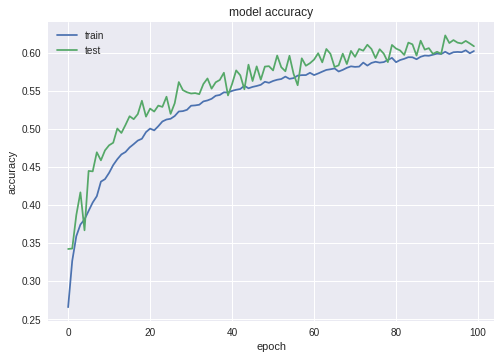

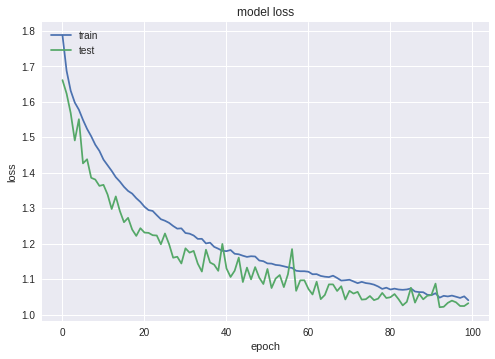

In [12]:
#  summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('cnn_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[Text(93.8,0.5,'True label'), Text(0.5,83,'Predicted label')]

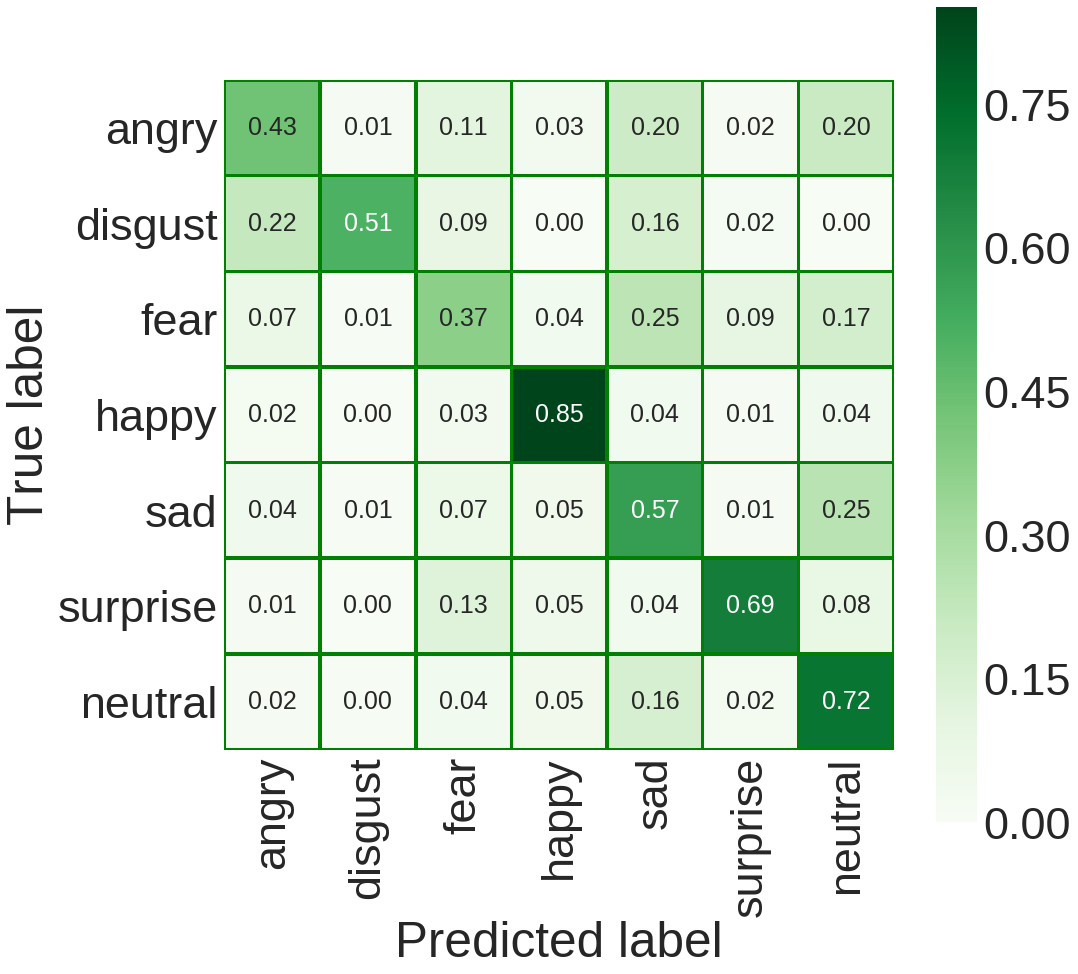

In [13]:
# Plot a confusion matrix
emotions_text = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

y_pred = model.predict_classes(x_validation)
y_true = np.asarray([np.argmax(i) for i in y_validation])

cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=4.5) 
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=2.5, square=True, linecolor="Green", 
                    cmap="Greens", yticklabels=emotions_text, xticklabels=emotions_text, vmin=0, vmax=np.max(cm_normalised), 
                    fmt=".2f", annot_kws={"size": 25})
ax.set(xlabel='Predicted label', ylabel='True label')

In [14]:
beta=1.0
score = fbeta_score(y_true, y_pred, average='micro', beta=beta)
print("fbeta = {}, beta = {}".format(score, beta))

fbeta = 0.6299804959598774, beta = 1.0


In [0]:
model_json = model.to_json()
with open("arch.json","w") as json_file:
     json_file.write(model_json)

files.download("arch.json")

In [0]:
from google.colab import files

model.save('weights.h5')
files.download('weights.h5')